## EDA for tweets

In this notebook I explored provided tweets datasets.
The analysis consists of three parts: 
1. Data visualization 
2. Text analysis 
3. Embedding similarity and clustering

In [1]:
import re 
import os
import collections
import string

import jsonlines
import torch
import nltk
import scipy.stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ast import literal_eval
from itertools import chain
from collections import Counter

from tqdm import tqdm, trange
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from nltk.cluster import KMeansClusterer
from wordcloud import WordCloud
from sklearn import cluster
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances, pairwise_distances_argmin
from scipy.optimize import linear_sum_assignment

In [2]:
# read data, add column denoting file number

df1 = pd.read_excel('Portuguese_tweets_with_text_1.xlsx')
df1['file'] = 1
df2 = pd.read_excel('Portuguese_tweets_with_text_2.xlsx')
df2['file'] = 2
df = pd.concat([df1,df2]).reset_index()
df = df[['TweetID','HandLabel','AnnotatorID','lang','text', 'file']]
df

,TweetID,HandLabel,AnnotatorID,lang,text,file
0,387164512995930112,Neutral,8,pt,"WildCat, o robot de quatro patas que corre a 2...",1
1,387164677152964608,Positive,8,pt,Parem de olhar para o meu telemovel quando est...,1
2,387165113347608576,Neutral,8,pt,@scrismelo Porque ainda não acordaste?!,1
3,387165245263073280,Neutral,8,pt,@TejoPaulo boa opção!,1
4,387165385747095616,Neutral,8,pt,RT @joaomhenrique: O corte nas pensões de sobr...,1
...,...,...,...,...,...,...
1879,388066311966048320,Positive,8,pt,Adoro os pés dos bebes,2
1880,388066431641743424,Neutral,8,pt,amanha vou acordar as 8h ajudem me pff,2
1881,388066551909580800,Positive,8,pt,Alejandro Marque é o ciclista do ano http://t....,2
1882,388066745568985088,Negative,8,pt,lol pessoas que me julgam pelo meu gosto music...,2


In [3]:
# add link to tweet, use the fact username is ignored

df['Tweet link'] = df['TweetID'].apply(lambda x: f'https://twitter.com/x/status/{x}')

### Data visualizations 

<AxesSubplot: >

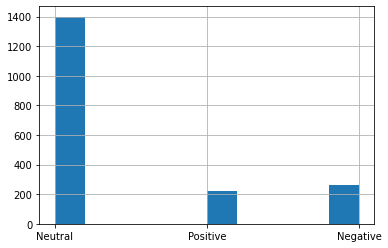

In [4]:
# labels distribution

df['HandLabel'].hist()

In [5]:
# language counts: most are Portuguese (probably automatically detected?)

df['lang'].value_counts()

pt     1843
es       21
en        7
und       3
it        2
ca        2
fr        2
tl        1
cs        1
et        1
ht        1
Name: lang, dtype: int64

In [6]:
# all tweets are labeled by the same annotator

df['AnnotatorID'].value_counts()

8    1884
Name: AnnotatorID, dtype: int64

(0.0, 150.0)

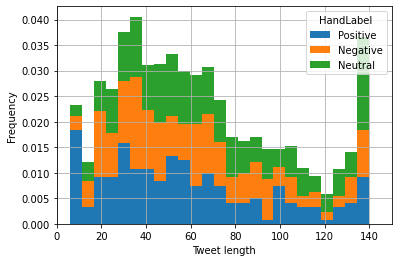

In [7]:
# label distribution as function of length
## Short tweets tend to be more positive. There are many tweets with maximal length
## Distribution resembles truncated lognormal

df['text_len']=df['text'].apply(lambda x: len(x))
(df.astype({'HandLabel' : 
            pd.CategoricalDtype(['Positive', 'Negative', 'Neutral'], 
                                ordered = True)})).pivot(columns='HandLabel').text_len.plot(kind='hist', stacked=True, bins=25, density=True, grid=True)
plt.xlabel('Tweet length')
plt.xlim(0,150)

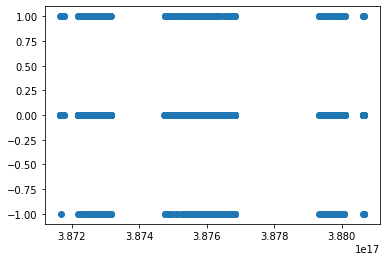

In [8]:
## Tweets appear to have similar distribution across labels by tweet id/time 
# (tweet ids aren't necessarily linearly depend on time) 

lab_to_n = {'Neutral': 0, 'Positive': 1, 'Negative': -1}
plt.scatter(df['TweetID'].tolist(), [lab_to_n[x] for x in df['HandLabel']])

Text(0.5, 0, 'Tweet ID')

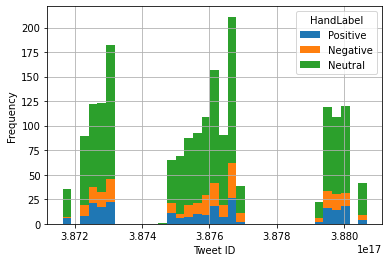

In [9]:
# There seem to be no time dependancy for tweet sentiment labeled
## Data is sampled from 3 separate continous ranges of tweet ids 

(df.astype({'HandLabel' : 
            pd.CategoricalDtype(['Positive', 'Negative', 'Neutral'], 
                                ordered = True)})).pivot(columns='HandLabel').TweetID.plot(kind='hist', stacked=True, bins=35, grid=True)
plt.xlabel('Tweet ID')

<AxesSubplot: ylabel='Frequency'>

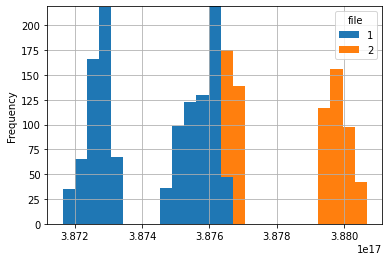

In [10]:
# files are separated chronologically;
# there is no relation between continous ranges and file split 

df.pivot(columns='file').TweetID.plot(kind='hist',  stacked=True, bins=25, grid=True)

### Data cleaning and text analysis

In [11]:
# extract links, extract retweets and usernames, clean and normalize tweet text

link_pattern = r'(https?://\S+)'
link_pattern_no_capture = r'https?://\S+'
df['extr_link'] = df['text'].apply(lambda x: re.findall(link_pattern, x))
# df['extr_link'] = df['extr_link'].apply(lambda x: x[0] if len(x)==1 else None if len(x)==0 else x)
df['text_norm'] = df['text'].apply(lambda x: ''.join(re.split(link_pattern_no_capture,x)))
df['rt'] = df['text_norm'].apply(lambda x: re.findall('(?<=RT )(.*?):(?<=)', x))
df['rt'] = df['rt'].apply(lambda x: x[0] if len(x)>0 else None)
#fix RT
df['text_norm'] = df['text_norm'].apply(lambda x: re.sub('(?<=RT )(.*?):(?<=)','rt_username',x))
df['name_tag'] = df['text_norm'].apply(lambda x: re.findall(r'(@s?\S+)', x ))
df

,TweetID,HandLabel,AnnotatorID,lang,text,file,Tweet link,text_len,extr_link,text_norm,rt,name_tag
0,387164512995930112,Neutral,8,pt,"WildCat, o robot de quatro patas que corre a 2...",1,https://twitter.com/x/status/387164512995930112,79,[http://t.co/jd2QaXCYul],"WildCat, o robot de quatro patas que corre a 2...",None,[]
1,387164677152964608,Positive,8,pt,Parem de olhar para o meu telemovel quando est...,1,https://twitter.com/x/status/387164677152964608,61,[],Parem de olhar para o meu telemovel quando est...,None,[]
2,387165113347608576,Neutral,8,pt,@scrismelo Porque ainda não acordaste?!,1,https://twitter.com/x/status/387165113347608576,39,[],@scrismelo Porque ainda não acordaste?!,None,[@scrismelo]
3,387165245263073280,Neutral,8,pt,@TejoPaulo boa opção!,1,https://twitter.com/x/status/387165245263073280,21,[],@TejoPaulo boa opção!,None,[@TejoPaulo]
4,387165385747095616,Neutral,8,pt,RT @joaomhenrique: O corte nas pensões de sobr...,1,https://twitter.com/x/status/387165385747095616,140,[],RT rt_username O corte nas pensões de sobreviv...,@joaomhenrique,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
1879,388066311966048320,Positive,8,pt,Adoro os pés dos bebes,2,https://twitter.com/x/status/388066311966048320,22,[],Adoro os pés dos bebes,None,[]
1880,388066431641743424,Neutral,8,pt,amanha vou acordar as 8h ajudem me pff,2,https://twitter.com/x/status/388066431641743424,38,[],amanha vou acordar as 8h ajudem me pff,None,[]
1881,388066551909580800,Positive,8,pt,Alejandro Marque é o ciclista do ano http://t....,2,https://twitter.com/x/status/388066551909580800,59,[http://t.co/dXQeAeUlme],Alejandro Marque é o ciclista do ano,None,[]
1882,388066745568985088,Negative,8,pt,lol pessoas que me julgam pelo meu gosto music...,2,https://twitter.com/x/status/388066745568985088,61,[],lol pessoas que me julgam pelo meu gosto music...,None,[]


In [12]:
# see link count distribution in tweets

df['extr_link'].apply(lambda x: len(x)).value_counts()

0    1436
1     431
2      16
4       1
Name: extr_link, dtype: int64

In [13]:
# see user mentions count distribution in tweets

df['name_tag'].apply(lambda x: len(x)).value_counts()

0    1388
1     407
2      74
3       8
4       3
6       2
5       2
Name: name_tag, dtype: int64

In [14]:
df['extr_link_cnt']=df['extr_link'].apply(lambda x: len(x))

<AxesSubplot: ylabel='Frequency'>

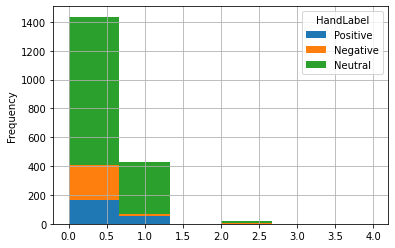

In [15]:
## Almost none of negative tweets have links

(df.astype({'HandLabel' : 
            pd.CategoricalDtype(['Positive', 'Negative', 'Neutral'], 
                                ordered = True)})).pivot(columns='HandLabel').extr_link_cnt.plot(kind='hist',  stacked=True, bins=6, grid=True)

In [16]:
# Check frequently posted links (for potential spam detection)
## Maximum count of same link is 4 which doesn't indicate spam

links = df['extr_link'].apply(lambda x: x[0] if len(x)>0 else None)
mylist =  list(chain.from_iterable(df['extr_link']))

counter = Counter(mylist)   
dup_dict = {k:c for k, c in counter.items() if c > 1}
print('Duplicates')
for d in dup_dict:
    print(d, dup_dict[d])

Duplicates
http://t.co/MElaZFAN53 4
http://t.co/MDmhqgtnSp 2
http://t.co/wmtdegm81p 2
http://t.co/zH… 2
http://t.co/… 2
http://t.co/zHJajJihDe 4
http://t.co/zHJa… 3
http://t.co/zHJ… 2
http://t.co/f2… 2
http://t.co/zHJaj… 4
http://t.co/hm1bc4lVsg 2
http://t.co/eWGESzr49n 2
http://t.c… 2


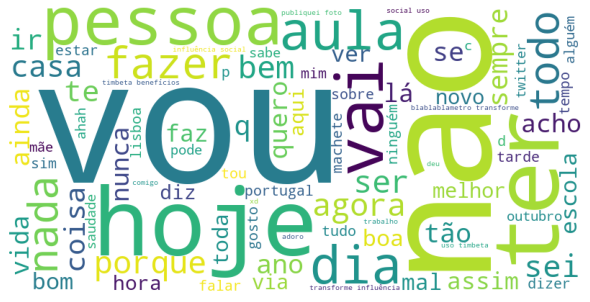

In [17]:
# Check most frequent words after removing stopwords

stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords += ['rt', 'rtusername', '']
word_list =  [x.lower() for x in list(chain.from_iterable(df['text_norm'].str.split())) 
              if x.lower().translate(str.maketrans('', '', string.punctuation)) not in stopwords]
c = Counter(word_list)   

wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 10).generate(' '.join(word_list))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Cosine similarity

In [18]:
# Check similarity between tweets
tweets = list(df['text_norm'])
texts = list(df['text'])
model_name = 'stsb-xlm-r-multilingual'#'paraphrase-multilingual-mpnet-base-v2' # all-distilroberta-v1
model = SentenceTransformer(f'sentence-transformers/{model_name}')
embeddings = model.encode(tweets)

In [19]:
dist = pairwise_distances(embeddings, embeddings, metric='cosine')
dist.min(), dist.max()

(0.0, 1.3474323)

In [20]:
flat_dists = dist[~np.eye(dist.shape[0],dtype=bool)].reshape(-1)
mean, scale = scipy.stats.norm.fit(flat_dists)
print(f'Mean: {mean:.4f}, scale: {scale:.4f}')

Mean: 0.8028, scale: 0.1539


Text(0, 0.5, 'Probability density')

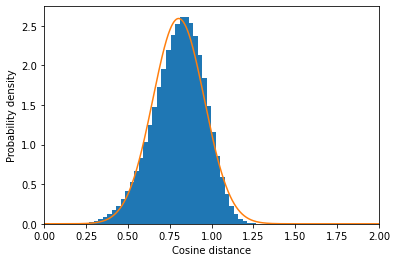

In [21]:
# Distances are distributes aproximately normally

x_l = np.linspace(0,2,10000)
plt.hist(flat_dists, bins=50, density=True)
plt.plot(x_l, scipy.stats.norm.pdf(x_l, mean, scale))
plt.xlim(0,2)
plt.xlabel('Cosine distance')
plt.ylabel('Probability density')

In [22]:
# define array of pairs of similar and distant tweets
close = np.argwhere(dist < 0.05)
far = np.argwhere(dist > 1.3)

In [23]:
# In case there are different labels for similar tweets:
## Try to fix labels based on most similar tweets

labs = []
for i in range(len(dist)):
    my_dists = dist[i]
    my_close = np.argwhere(my_dists < 0.05).reshape(-1)
    
    new_lab = df.iloc[i]['HandLabel']
    if len(my_close)>1:
        my_labs = df.iloc[my_close]['HandLabel'].value_counts()
        if my_labs.max() > 1:
            new_lab = my_labs.keys()[my_labs.argmax()]
    labs.append(new_lab)
df['FixedLabel'] = labs

In [24]:
# There are only 5 tweets where label was fixed

df[df['HandLabel']!=df['FixedLabel']]

,TweetID,HandLabel,AnnotatorID,lang,text,file,Tweet link,text_len,extr_link,text_norm,rt,name_tag,extr_link_cnt,FixedLabel
760,387547280762736576,Positive,8,pt,Eu publiquei uma nova foto no Facebook http://...,1,https://twitter.com/x/status/387547280762736576,61,[http://t.co/gQhQhRC4JY],Eu publiquei uma nova foto no Facebook,None,[],1,Neutral
1001,387606895898677184,Positive,8,pt,RT @brenopepa: Tenho 3462 pontos no #Blablabla...,1,https://twitter.com/x/status/387606895898677184,140,[http://t.co/zHJ…],RT rt_username Tenho 3462 pontos no #Blablabla...,@brenopepa,[],1,Neutral
1004,387607498985074688,Positive,8,pt,RT @brenopepa: Tenho 3462 pontos no #Blablabla...,1,https://twitter.com/x/status/387607498985074688,140,[http://t.co/zHJaj…],RT rt_username Tenho 3462 pontos no #Blablabla...,@brenopepa,[],1,Neutral
1041,387612848857567232,Positive,8,pt,RT @brenopepa: Tenho 3524 pontos no #Blablabla...,1,https://twitter.com/x/status/387612848857567232,140,[http://t.co/zH…],RT rt_username Tenho 3524 pontos no #Blablabla...,@brenopepa,[],1,Neutral
1641,387970713589911616,Negative,8,pt,Publiquei uma foto nova no Facebook http://t.c...,2,https://twitter.com/x/status/387970713589911616,58,[http://t.co/nMewSl1Z28],Publiquei uma foto nova no Facebook,None,[],1,Neutral


In [25]:
# See pairs of non-identical tweets with low cosine distance excluding/including particular stopwords

import string
def print_texts(close, tweets, texts, blocklist=()):
    for p in close:
        if p[0]>=p[1]:
            continue
        t1 = tweets[p[0]].lower().translate(str.maketrans('', '', string.punctuation))
        t2 = tweets[p[1]].lower().translate(str.maketrans('', '', string.punctuation))
        if t1 == t2:
            continue
        skip = False
        for w in blocklist:
            if w.lower() in t1 or w.lower() in t2:
                skip=True
                break
        if skip:
            continue
        text1 = texts[p[0]]
        text2 = texts[p[1]]
        print(p[0], text1, '\n',p[1], text2)

def get_similar_keyword(close, tweets, keyword):
    sim = set()
    
    for p in close:
        t1 = tweets[p[0]].lower().translate(str.maketrans('', '', string.punctuation))
        t2 = tweets[p[1]].lower().translate(str.maketrans('', '', string.punctuation))
        if keyword in t1:
            sim.add(p[0])
        if keyword in t2:
            sim.add(p[1])
    return sim

In [26]:
# There are 28 tweets mentioning Facebook
df.iloc[ list(get_similar_keyword(close, tweets, 'facebook'))]

,TweetID,HandLabel,AnnotatorID,lang,text,file,Tweet link,text_len,extr_link,text_norm,rt,name_tag,extr_link_cnt,FixedLabel
256,387270487422042112,Neutral,8,pt,RT @chINESacute: O meu facebook andou a fumar ...,1,https://twitter.com/x/status/387270487422042112,52,[],RT rt_username O meu facebook andou a fumar me...,@chINESacute,[],0,Neutral
1154,387633406219399168,Neutral,8,pt,"Publiquei 5 fotos no Facebook no álbum ""Hoje |...",1,https://twitter.com/x/status/387633406219399168,91,[http://t.co/yjNapeZeHX],"Publiquei 5 fotos no Facebook no álbum ""Hoje |...",None,[],1,Neutral
1156,387633502985809920,Neutral,8,pt,Publiquei uma foto nova no Facebook http://t.c...,1,https://twitter.com/x/status/387633502985809920,58,[http://t.co/XOU212891o],Publiquei uma foto nova no Facebook,None,[],1,Neutral
17,387170173808939008,Neutral,8,pt,"Publiquei 13 fotos no Facebook no álbum ""House...",1,https://twitter.com/x/status/387170173808939008,91,[http://t.co/1IQJVn2cqM],"Publiquei 13 fotos no Facebook no álbum ""House...",None,[],1,Neutral
1434,387680294901276672,Negative,8,pt,Cada vez que me mandam pedidos de jogos no fac...,2,https://twitter.com/x/status/387680294901276672,73,[],Cada vez que me mandam pedidos de jogos no fac...,None,[],0,Negative
1564,387953838189457408,Neutral,8,pt,Publiquei uma foto nova no Facebook http://t.c...,2,https://twitter.com/x/status/387953838189457408,58,[http://t.co/LaqAtPplds],Publiquei uma foto nova no Facebook,None,[],1,Neutral
547,387315325781282816,Neutral,8,pt,#SouDoTempo em que ter 50 gostos no facebook e...,1,https://twitter.com/x/status/387315325781282816,68,[],#SouDoTempo em que ter 50 gostos no facebook e...,None,[],0,Neutral
1700,387984289868300288,Neutral,8,pt,Publiquei uma foto nova no Facebook http://t.c...,2,https://twitter.com/x/status/387984289868300288,58,[http://t.co/0vwJUqjYM8],Publiquei uma foto nova no Facebook,None,[],1,Neutral
170,387253646981095424,Neutral,8,pt,Eu publiquei uma nova foto no Facebook http://...,1,https://twitter.com/x/status/387253646981095424,61,[http://t.co/twGwkLAwAO],Eu publiquei uma nova foto no Facebook,None,[],1,Neutral
171,387253732574232576,Neutral,8,pt,Eu publiquei uma nova foto no Facebook http://...,1,https://twitter.com/x/status/387253732574232576,61,[http://t.co/OWtWxBNxNO],Eu publiquei uma nova foto no Facebook,None,[],1,Neutral


In [27]:
# 21 tweets mentioning YouTube
df.iloc[ list(get_similar_keyword(close, tweets, 'youtube'))]

,TweetID,HandLabel,AnnotatorID,lang,text,file,Tweet link,text_len,extr_link,text_norm,rt,name_tag,extr_link_cnt,FixedLabel
640,387508090980950016,Neutral,8,pt,Mariza sings #Nirvana ( Come As You Are ): ht...,1,https://twitter.com/x/status/387508090980950016,105,[http://t.co/iJsnO3pHv9],Mariza sings #Nirvana ( Come As You Are ): v...,None,[@youtube],1,Neutral
902,387588378092658688,Neutral,8,en,I liked a @YouTube video from @d4rkframe http:...,1,https://twitter.com/x/status/387588378092658688,104,[http://t.co/crSAmfKMSo],I liked a @YouTube video from @d4rkframe GORD...,None,"[@YouTube, @d4rkframe]",1,Neutral
9,387167016311746624,Positive,8,pt,Gostei de um vídeo do @YouTube http://t.co/PQW...,1,https://twitter.com/x/status/387167016311746624,73,[http://t.co/PQWctZzjRN],Gostei de um vídeo do @YouTube Maria Rui - O ...,None,[@YouTube],1,Positive
146,387248525018673216,Positive,8,pt,"Estou feliz , sou branco, vivo na europa, este...",1,https://twitter.com/x/status/387248525018673216,100,[http://t.co/5NBrsUhxxB)],"Estou feliz , sou branco, vivo na europa, este...",None,[@YouTube],1,Positive
1172,387636139236274176,Neutral,8,pt,Subscreve o canal youtube do site e fica a par...,1,https://twitter.com/x/status/387636139236274176,126,[http://t.co/Th5aizX4YJ],Subscreve o canal youtube do site e fica a par...,None,[],1,Neutral
1300,387666430931763200,Neutral,8,pt,Gostei de um vídeo do @YouTube http://t.co/jYS...,2,https://twitter.com/x/status/387666430931763200,79,[http://t.co/jYSBLywSvh],"Gostei de um vídeo do @YouTube 'I, Frankenste...",None,[@YouTube],1,Neutral
278,387275748438200320,Positive,8,pt,Gostei de um vídeo do @YouTube de @diogof29 ht...,1,https://twitter.com/x/status/387275748438200320,110,[http://t.co/eRELavNzj7],Gostei de um vídeo do @YouTube de @diogof29 C...,None,"[@YouTube, @diogof29]",1,Positive
155,387250319325138880,Positive,8,pt,I liked a @YouTube video from @ninnjanoob http...,1,https://twitter.com/x/status/387250319325138880,127,[http://t.co/IxCzDZXWR7],I liked a @YouTube video from @ninnjanoob ► B...,None,"[@YouTube, @ninnjanoob]",1,Positive
1071,387618510064844800,Positive,8,pt,Gostei de um vídeo do @YouTube http://t.co/GeR...,1,https://twitter.com/x/status/387618510064844800,132,[http://t.co/GeReTVTLfu],Gostei de um vídeo do @YouTube PlayStation Ex...,None,[@YouTube],1,Positive
700,387530920355713024,Neutral,8,pt,Gostei de um vídeo @YouTube http://t.co/pHJpyJ...,1,https://twitter.com/x/status/387530920355713024,78,[http://t.co/pHJpyJRVCQ],Gostei de um vídeo @YouTube - Dilemma ft. Kel...,None,[@YouTube],1,Neutral


In [28]:
# 74 tweets mentioning Tenho 

df.iloc[ list(get_similar_keyword(close, tweets, 'tenho'))]

,TweetID,HandLabel,AnnotatorID,lang,text,file,Tweet link,text_len,extr_link,text_norm,rt,name_tag,extr_link_cnt,FixedLabel
774,387551676254916608,Neutral,8,pt,A Terça feira tenho aulas muito longas e chata...,1,https://twitter.com/x/status/387551676254916608,69,[],A Terça feira tenho aulas muito longas e chata...,None,[],0,Neutral
903,387588885565292480,Negative,8,pt,Tenho todas as tardes livres mas mesmo assim f...,1,https://twitter.com/x/status/387588885565292480,57,[],Tenho todas as tardes livres mas mesmo assim f...,None,[],0,Negative
1032,387611920779714624,Neutral,8,pt,RT @brenopepa: Tenho 3524 pontos no #Blablabla...,1,https://twitter.com/x/status/387611920779714624,140,[http://t.co/zHJaj…],RT rt_username Tenho 3524 pontos no #Blablabla...,@brenopepa,[],1,Neutral
1630,387968529615425472,Neutral,8,pt,"tou com bué sono, mas não vou dormir porque de...",2,https://twitter.com/x/status/387968529615425472,78,[],"tou com bué sono, mas não vou dormir porque de...",None,[],0,Neutral
1547,387949589049143296,Neutral,8,pt,@JG1904 será que também pára no catacumbas? te...,2,https://twitter.com/x/status/387949589049143296,94,[],@JG1904 será que também pára no catacumbas? te...,None,"[@JG1904, @VelhoEstilo]",0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,387609028169592832,Negative,8,pt,Tenho o hábito de achar sempre que respondo as...,1,https://twitter.com/x/status/387609028169592832,99,[],Tenho o hábito de achar sempre que respondo as...,None,[],0,Negative
1016,387609251499094016,Neutral,8,pt,Tenho 3524 pontos no #Blablablametro. Transfor...,1,https://twitter.com/x/status/387609251499094016,130,[http://t.co/zHJajJihDe],Tenho 3524 pontos no #Blablablametro. Transfor...,None,[],1,Neutral
379,387294830893625280,Neutral,8,pt,"Como não te tenho aqui para me viciar, viciand...",1,https://twitter.com/x/status/387294830893625280,65,[],"Como não te tenho aqui para me viciar, viciand...",None,[],0,Neutral
124,387242254769074176,Neutral,8,pt,Tenho ao meu lado o ananás mais lindo desta vi...,1,https://twitter.com/x/status/387242254769074176,61,[],Tenho ao meu lado o ananás mais lindo desta vi...,None,[],0,Neutral


In [29]:
# See pairs of similar tweets excluding blocklist

print_texts(close, tweets, texts, ['facebook', 'tenho', 'bom dia','boa tarde', 'YouTube'])

147 Juro que estou farta disto 
 874 Estou farta dele
447 Boas noites 
 1253 boa noiteee
927 Estou tão triste. 
 1818 Sinto-me triste.
1260 Musicas tristes entram pelos ouvidos, e saem pelos olhos.. 
 1382 "músicas tristes entram pelos ouvidos e saem pelos olhos"
1506 eu adoro 
 1814 amei completamente


In [30]:
# See pairs of distant tweets excluding blocklist

print_texts(far, tweets, texts, [])

79 Em 2013 http://t.co/SdeWdXgI2x 
 205 Só a gata sensual sabe o porque de ter estado tão feliz na aula de história
133 Hoje também estamos por aqui:

http://t.co/G6qObC3Y5V http://t.co/47KBbJO3Tj 
 1135 'Fui mesmo mordido?', questiona vítima de ataque de tubarão: Um homem de 45 anos não queria acreditar no ataqu... http://t.co/4H0FM29180
210 Voltei à varanda http://t.co/mc4GMeCkRH 
 618 as mulheres são um perigo no trânsito!! um gajo distrai-se com uma sexy lips e espeta-se forte e feio!
210 Voltei à varanda http://t.co/mc4GMeCkRH 
 1325 O meu stor de maths e tao machista, ta sempre a gozar com as raparigas ainda por cima ha 20 rapazes na turma e nos somos so 7
276 Há aqui tantas pessoas que adoram humilhar as outras, só não percebem que fazem mais figuras que as pessoas que tentam humilhar. 
 431 I'm at Terminal Barraqueiro Cidade Nova (Lisboa) http://t.co/1wtzz1XmbT
299 atrás da minha casa, beef de cães 
 455 Sinceramente às vezes tenho alguma dificuldade em perceber se são rapariga

### Clustering with k-means

In [31]:
# Unsupervised clustering of tweets

n_classes = 3

epochs = 100

batch_size = 2048

def batches(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


def cluster_data(X_train, n_clusters=3): #, y_train
    minib_k_means = cluster.MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, max_no_improvement=None)

    minib_k_means.fit(X_train)
    return minib_k_means

In [32]:
# Choose cluster count based on silhouette score

cl_cnt = np.arange(3, 20)
silhs = []
for i in tqdm(cl_cnt):
    k_means = cluster_data(embeddings, i)
    pred = k_means.predict(embeddings)
#     print(len(pred))
    silhs.append(silhouette_score(embeddings, pred))
#     print(silhs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:21<00:00,  1.25s/it]


(0.0, 20.0)

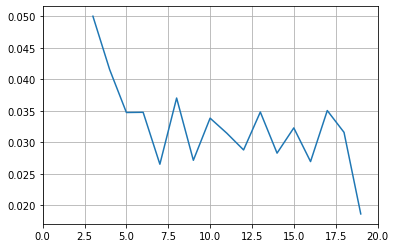

In [33]:
silhs = np.array(silhs)
plt.plot(cl_cnt, silhs)
plt.grid()
plt.xlim(0,20)

In [34]:
#Clusterize data

n_clusters = cl_cnt[silhs.argmax()]
print(f'Num clusters: {n_clusters}')
k_means = cluster_data(embeddings, n_clusters)
pred = k_means.predict(embeddings)
mbk_means_cluster_centers = k_means.cluster_centers_

Num clusters: 3


In [35]:
# Add index of cluster for each tweet

df['cluster'] = pred
df

,TweetID,HandLabel,AnnotatorID,lang,text,file,Tweet link,text_len,extr_link,text_norm,rt,name_tag,extr_link_cnt,FixedLabel,cluster
0,387164512995930112,Neutral,8,pt,"WildCat, o robot de quatro patas que corre a 2...",1,https://twitter.com/x/status/387164512995930112,79,[http://t.co/jd2QaXCYul],"WildCat, o robot de quatro patas que corre a 2...",None,[],1,Neutral,2
1,387164677152964608,Positive,8,pt,Parem de olhar para o meu telemovel quando est...,1,https://twitter.com/x/status/387164677152964608,61,[],Parem de olhar para o meu telemovel quando est...,None,[],0,Positive,2
2,387165113347608576,Neutral,8,pt,@scrismelo Porque ainda não acordaste?!,1,https://twitter.com/x/status/387165113347608576,39,[],@scrismelo Porque ainda não acordaste?!,None,[@scrismelo],0,Neutral,0
3,387165245263073280,Neutral,8,pt,@TejoPaulo boa opção!,1,https://twitter.com/x/status/387165245263073280,21,[],@TejoPaulo boa opção!,None,[@TejoPaulo],0,Neutral,1
4,387165385747095616,Neutral,8,pt,RT @joaomhenrique: O corte nas pensões de sobr...,1,https://twitter.com/x/status/387165385747095616,140,[],RT rt_username O corte nas pensões de sobreviv...,@joaomhenrique,[],0,Neutral,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,388066311966048320,Positive,8,pt,Adoro os pés dos bebes,2,https://twitter.com/x/status/388066311966048320,22,[],Adoro os pés dos bebes,None,[],0,Positive,1
1880,388066431641743424,Neutral,8,pt,amanha vou acordar as 8h ajudem me pff,2,https://twitter.com/x/status/388066431641743424,38,[],amanha vou acordar as 8h ajudem me pff,None,[],0,Neutral,1
1881,388066551909580800,Positive,8,pt,Alejandro Marque é o ciclista do ano http://t....,2,https://twitter.com/x/status/388066551909580800,59,[http://t.co/dXQeAeUlme],Alejandro Marque é o ciclista do ano,None,[],1,Positive,1
1882,388066745568985088,Negative,8,pt,lol pessoas que me julgam pelo meu gosto music...,2,https://twitter.com/x/status/388066745568985088,61,[],lol pessoas que me julgam pelo meu gosto music...,None,[],0,Negative,2


In [36]:
# Try to match between sentiment labels and clusters

def get_cost_matrix(y_pred, y, nc=3):
    C = np.zeros((nc, y.max() + 1))
    for pred, label in zip(y_pred, y):
        C[pred, label] += 1 
    C = C / C.sum(axis=0, keepdims=True)
    return C

def assign_classes_hungarian(C):
    row_ind, col_ind = linear_sum_assignment(C, maximize=True)
    ri, ci = np.arange(C.shape[0]), np.zeros(C.shape[0])
    ci[row_ind] = col_ind

    # for overclustering, rest is assigned to best matching class
    mask = np.ones(C.shape[0], dtype=bool)
    mask[row_ind] = False
    ci[mask] = C[mask, :].argmax(1)
    return ri.astype(int), ci.astype(int)

In [37]:
# Assign labels to clusters; 
# there is not much correlation between tweet embedding and sentiment

label2ind = {'Neutral': 0, 'Negative': 1, 'Positive': 2}
ind2label = {v:k for k,v in label2ind.items()}
C = get_cost_matrix(df['cluster'], 
                    np.array([label2ind[x] for x in df['HandLabel']]), nc=n_clusters)
r, c = assign_classes_hungarian(C)
df['label_from_cluster'] = [ind2label[c[x]] for x in pred]
C

array([[0.14010007, 0.36015326, 0.06696429],
       [0.58541816, 0.18390805, 0.77232143],
       [0.27448177, 0.4559387 , 0.16071429]])

In [38]:
df[df['HandLabel']==df['label_from_cluster']].shape

(651, 16)

In [39]:
# Most typical tweets of each cluster

df['dist_from_center']=(((embeddings-mbk_means_cluster_centers[pred])**2).sum(axis=1))**(1/2)
df.sort_values('dist_from_center').groupby('cluster').head(3).sort_values('cluster')

,TweetID,HandLabel,AnnotatorID,lang,text,file,Tweet link,text_len,extr_link,text_norm,rt,name_tag,extr_link_cnt,FixedLabel,cluster,label_from_cluster,dist_from_center
678,387523607674773504,Neutral,8,pt,"Ai a minha tl está muito parada, não gosto.",1,https://twitter.com/x/status/387523607674773504,43,[],"Ai a minha tl está muito parada, não gosto.",None,[],0,Neutral,0,Negative,4.546979
38,387217098725801984,Neutral,8,pt,Se eu não te falo é porque não quero mais papo...,1,https://twitter.com/x/status/387217098725801984,64,[],Se eu não te falo é porque não quero mais papo...,None,[],0,Neutral,0,Negative,4.584388
1259,387661098649796608,Neutral,8,pt,Demorei mt para aqui chegar... Se achas msm qu...,2,https://twitter.com/x/status/387661098649796608,88,[],Demorei mt para aqui chegar... Se achas msm qu...,None,[],0,Neutral,0,Negative,4.736284
229,387265377375645696,Neutral,8,it,"Toca porra. Tenho bue tpc's, ate mete dò.",1,https://twitter.com/x/status/387265377375645696,41,[],"Toca porra. Tenho bue tpc's, ate mete dò.",None,[],0,Neutral,1,Positive,4.244184
261,387272155185963008,Neutral,8,pt,@Joana_LP enviei-te uma DM.,1,https://twitter.com/x/status/387272155185963008,27,[],@Joana_LP enviei-te uma DM.,None,[@Joana_LP],0,Neutral,1,Positive,4.459321
372,387294018687598592,Negative,8,pt,o jonatas era assim agr '' de certeza é pegado...,1,https://twitter.com/x/status/387294018687598592,83,[],o jonatas era assim agr '' de certeza é pegado...,None,[],0,Negative,1,Positive,4.959826
1665,387976189580939328,Neutral,8,pt,@luis_grave @paulasbrito1 é a estupidez e o pr...,2,https://twitter.com/x/status/387976189580939328,93,[],@luis_grave @paulasbrito1 é a estupidez e o pr...,None,"[@luis_grave, @paulasbrito1]",0,Neutral,2,Neutral,6.017758
946,387598419529060416,Neutral,8,pt,A minha turma é uma cambada de burros ! meia h...,1,https://twitter.com/x/status/387598419529060416,84,[],A minha turma é uma cambada de burros ! meia h...,None,[],0,Neutral,2,Neutral,6.269856
191,387257194535583680,Negative,8,pt,Sou tão estúpida e parva e sei lá o que e o ca...,1,https://twitter.com/x/status/387257194535583680,85,[],Sou tão estúpida e parva e sei lá o que e o ca...,None,[],0,Negative,2,Neutral,6.421464


<AxesSubplot: ylabel='Frequency'>

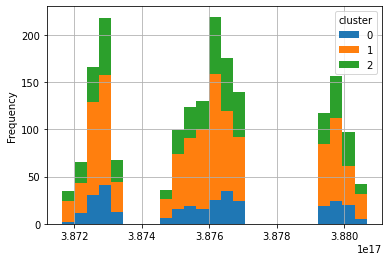

In [40]:
# Time dependence of clusters

df.pivot(columns='cluster').TweetID.plot(kind='hist',  stacked=True, bins=25, grid=True) #density=True,